# sPlot Vegetation Surveys — India's Data Gap

[sPlot](https://www.idiv.de/en/splot.html) provides structured vegetation community surveys (full species lists with relative abundance per plot), complementing GBIF's point occurrence records. Our study combines both data sources for trait mapping. Here we quantify India's representation in sPlot.

In [1]:
import sys; sys.path.insert(0, ".")
from _shared import *
setup_plotting()

india_df = pd.read_parquet(CACHE_DIR / "india_df.parquet")
total_global = int(pd.read_json(CACHE_DIR / "metadata.json", typ="series", convert_dates=False)["total_global"])

In [2]:
# Load sPlot filtered data and extract India subset
splot_all = pd.read_parquet(SPLOT_PATH)
total_splot_plots = splot_all.PlotObservationID.nunique()
total_splot_species = splot_all.speciesname.nunique()

# Filter to India bounding box (no country column available)
india_splot = splot_all.query("6 <= Latitude <= 38 and 67 <= Longitude <= 98")

india_splot_plots = india_splot.PlotObservationID.nunique()
india_splot_species = india_splot.speciesname.nunique()

dash = "\u2014"
print("=== sPlot vs GBIF: India Comparison ===")
print(f"{'':30s} {'sPlot':>12s} {'GBIF':>12s}")
print(f"{'Global records':30s} {len(splot_all):>12,} {total_global:>12,}")
print(f"{'Global plots/observations':30s} {total_splot_plots:>12,} {dash:>12s}")
print(f"{'India records':30s} {len(india_splot):>12,} {len(india_df):>12,}")
print(f"{'India plots/observations':30s} {india_splot_plots:>12,} {dash:>12s}")
print(f"{'India unique species':30s} {india_splot_species:>12,} {india_df.species.nunique():>12,}")
print(f"{'India share of global':30s} {india_splot_plots/total_splot_plots:>11.2%} {len(india_df)/total_global:>11.2%}")
print(f"\nsPlot PFT breakdown in India:")
print(india_splot.pft.value_counts().to_string())

# Clean up large dataframe
del splot_all

# Cache India sPlot subset for summary notebook
india_splot.to_parquet(CACHE_DIR / "india_splot.parquet")
pd.Series({
    "total_splot_plots": total_splot_plots,
    "total_splot_species": total_splot_species,
}).to_json(CACHE_DIR / "splot_metadata.json")

=== sPlot vs GBIF: India Comparison ===
                                      sPlot         GBIF
Global records                   39,457,558  338,978,088
Global plots/observations         2,216,180            —
India records                        56,662      244,100
India plots/observations              5,489            —
India unique species                  1,331        8,881
India share of global                0.25%       0.07%

sPlot PFT breakdown in India:
pft
Grass    42530
Shrub    10607
Tree      3525


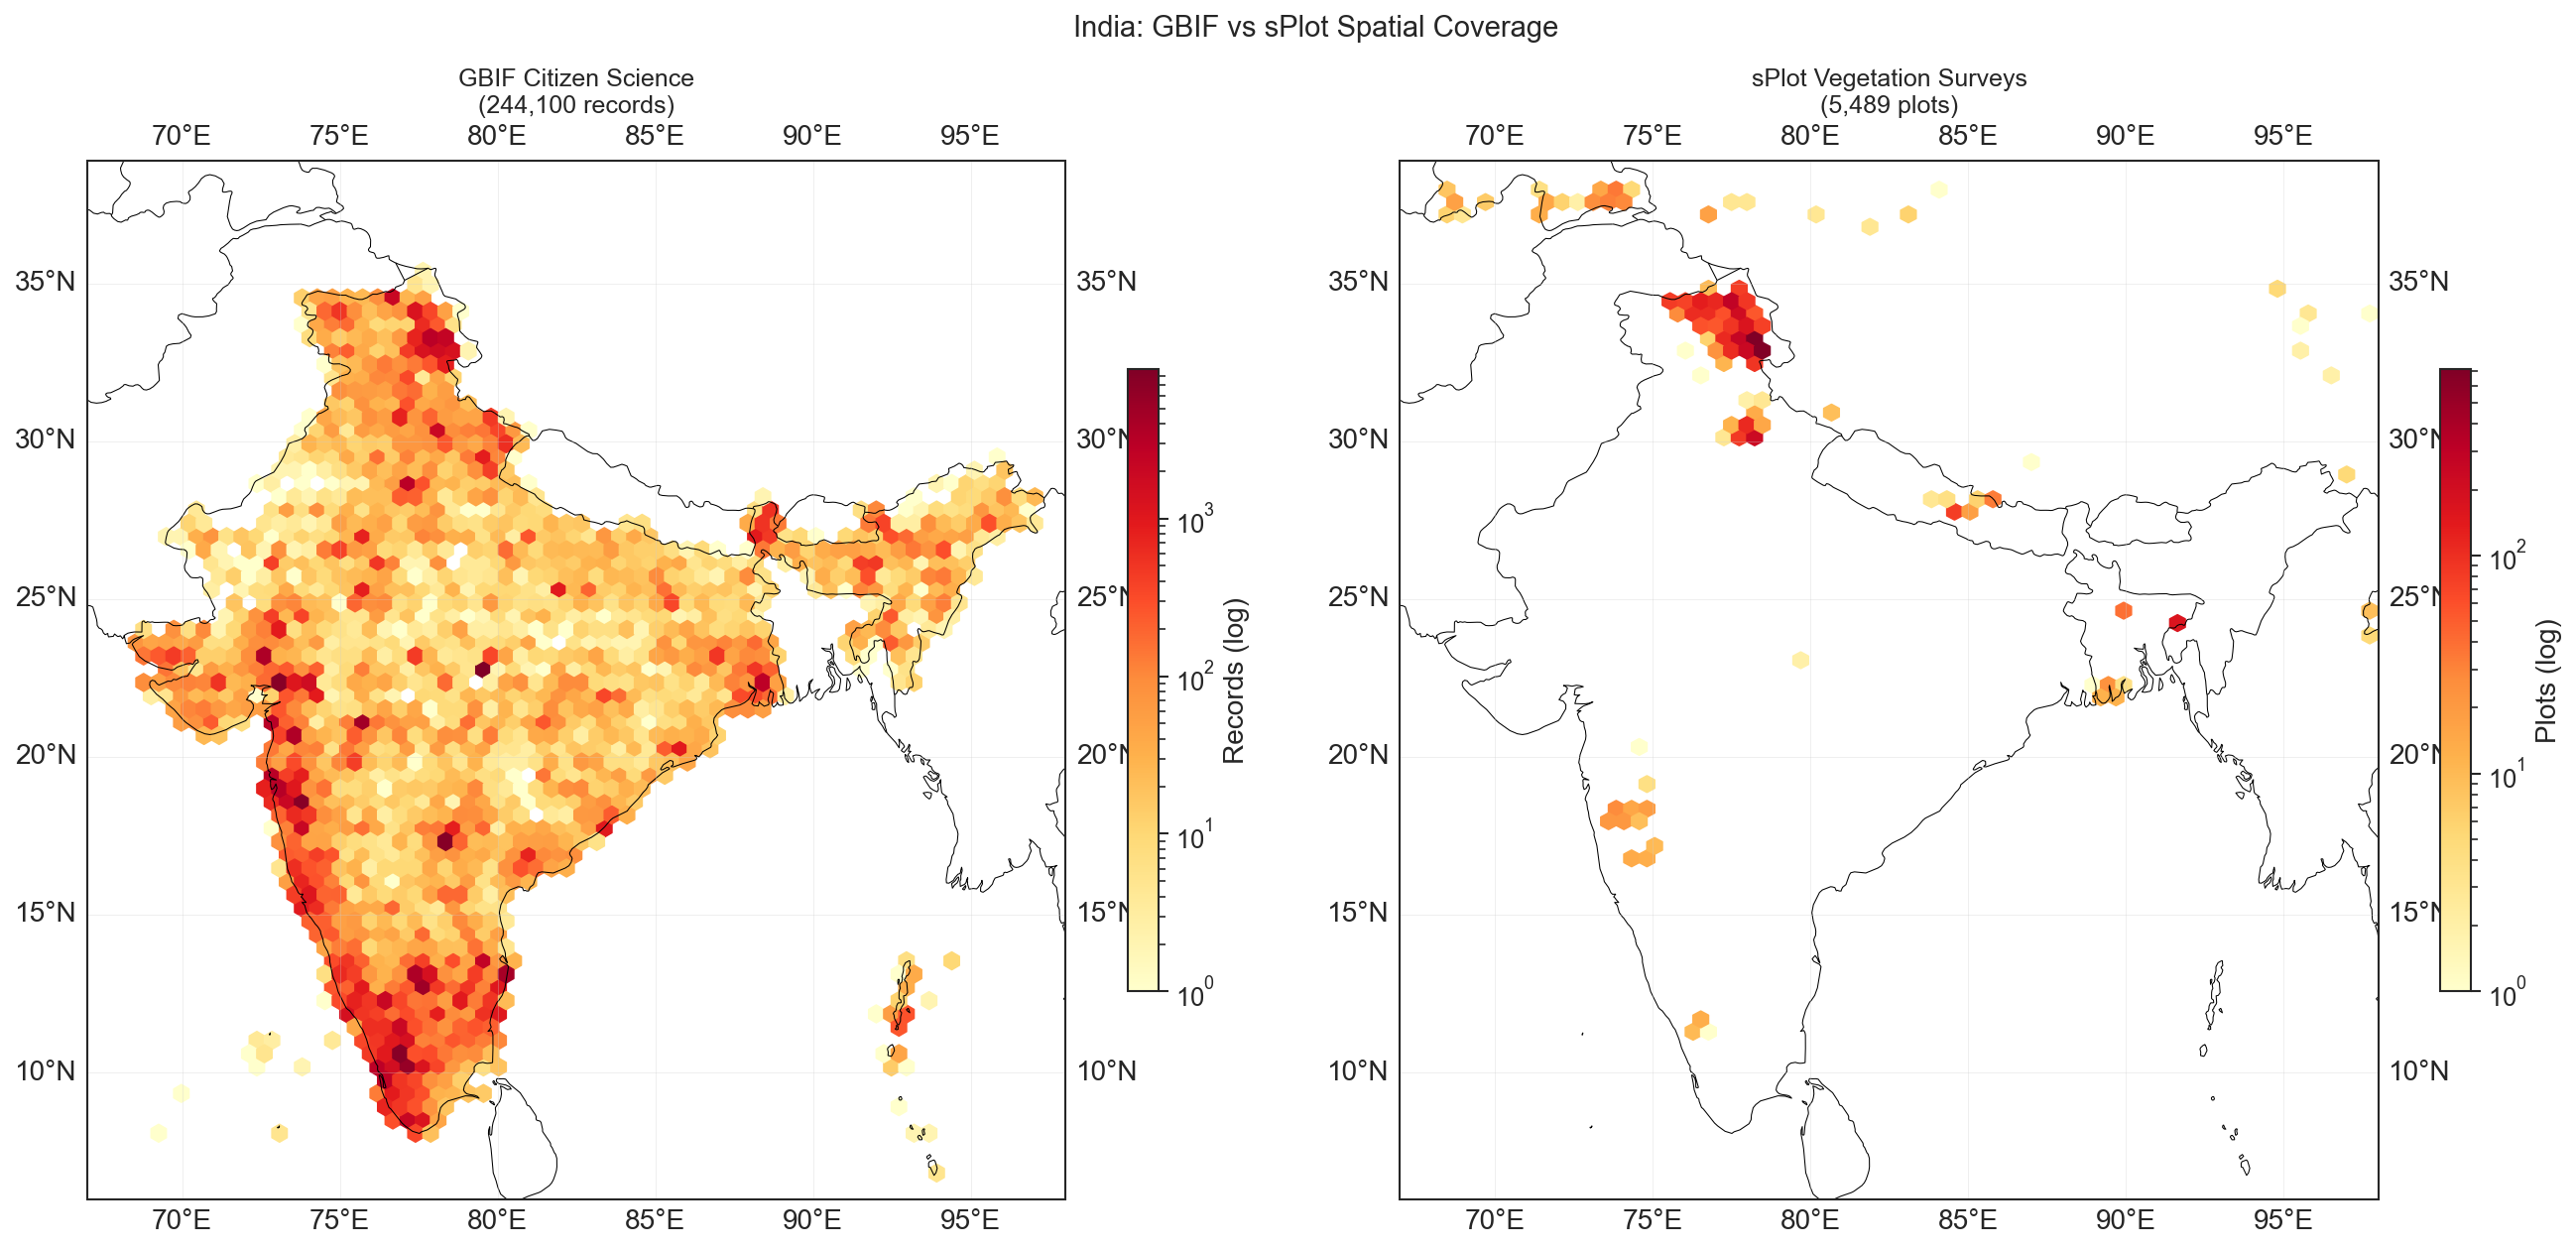

In [3]:
# Figure: Side-by-side GBIF vs sPlot coverage maps of India
india_geo = india_df.dropna(subset=["decimallatitude", "decimallongitude"])

fig, axes = plt.subplots(
    1, 2, figsize=(18, 8),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for ax in axes:
    ax.set_extent([67, 98, 6, 38])
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5)

# Left: GBIF hexbin density
hb1 = axes[0].hexbin(
    india_geo.decimallongitude, india_geo.decimallatitude,
    gridsize=60, bins="log", cmap="YlOrRd", mincnt=1,
    transform=ccrs.PlateCarree(),
)
axes[0].set_title(f"GBIF Citizen Science\n({len(india_df):,} records)", fontsize=12)
plt.colorbar(hb1, ax=axes[0], shrink=0.6, label="Records (log)")

# Right: sPlot hexbin density (one record per unique plot)
splot_locs = india_splot.drop_duplicates(subset="PlotObservationID")
hb2 = axes[1].hexbin(
    splot_locs.Longitude, splot_locs.Latitude,
    gridsize=60, bins="log", cmap="YlOrRd", mincnt=1,
    transform=ccrs.PlateCarree(),
)
axes[1].set_title(f"sPlot Vegetation Surveys\n({india_splot_plots:,} plots)", fontsize=12)
plt.colorbar(hb2, ax=axes[1], shrink=0.6, label="Plots (log)")

fig.suptitle(
    "India: GBIF vs sPlot Spatial Coverage", fontsize=14, y=1.02
)
plt.tight_layout()
plt.show()

In [4]:
# Species overlap: sPlot vs GBIF in India
gbif_species = set(india_df.species.dropna().str.lower().unique())
splot_species = set(india_splot.speciesname.dropna().unique())  # already lowercase

both = gbif_species & splot_species
gbif_only = gbif_species - splot_species
splot_only = splot_species - gbif_species

print("=== Species Overlap: GBIF vs sPlot in India ===")
print(f"GBIF only:        {len(gbif_only):,} species")
print(f"sPlot only:       {len(splot_only):,} species")
print(f"In both:          {len(both):,} species")
print(f"Combined unique:  {len(gbif_only | splot_only | both):,} species")
print(f"\nsPlot adds {len(splot_only):,} species not found in GBIF for India")
print(f"({len(splot_only) / len(gbif_only | splot_only | both):.1%} of combined total)")

print("\n--- Summary for journalist ---")
print(f"India has {india_splot_plots:,} sPlot vegetation survey plots vs {len(india_df):,} GBIF records.")
print(f"sPlot represents just {india_splot_plots/total_splot_plots:.2%} of the global sPlot database")
print(f"({total_splot_plots:,} plots), reinforcing the pattern of underrepresentation.")
print(f"However, combining both sources increases India's species coverage from")
print(f"{len(gbif_species):,} to {len(gbif_only | splot_only | both):,} species (+{len(splot_only):,} from sPlot).")

=== Species Overlap: GBIF vs sPlot in India ===
GBIF only:        7,901 species
sPlot only:       351 species
In both:          980 species
Combined unique:  9,232 species

sPlot adds 351 species not found in GBIF for India
(3.8% of combined total)

--- Summary for journalist ---
India has 5,489 sPlot vegetation survey plots vs 244,100 GBIF records.
sPlot represents just 0.25% of the global sPlot database
(2,216,180 plots), reinforcing the pattern of underrepresentation.
However, combining both sources increases India's species coverage from
8,881 to 9,232 species (+351 from sPlot).
